In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import os, sys

In [ ]:
mnist = tf.keras.datasets.

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# map inputs to -1 +1 for better training
X_train, X_test = X_train/255.0 * 2 - 1, X_test/255.0 * 2 - 1
print(X_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [ ]:
# Flatten the data
N, H, W = X_train.shape
D = H * W
X_train = X_train.reshape(-1, D)
X_test = X_test.reshape(-1, D)

In [ ]:
# Dimensionality of the latent space
latent_dim = 100

In [ ]:
# Get the generator model
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [ ]:
# Get the discriminator model
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [ ]:
# compile both models in preparation for training

# build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

# build and compile the combined model
generator = build_generator(latent_dim)

# create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# pass noise through generator to get an image
img = generator(z)

# make sure only the generator is trained
discriminator.trainable = False

# the true output is fake, but we label them real
fake_pred = discriminator(img)

# create the combined model object
combined_model = Model(z, fake_pred)

# compile the combined model
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)

In [ ]:
# Train the GAN

# config
batch_size = 32
epochs = 30000
sample_period = 200  # every sample period steps generate and save some data

# create batch labels to use when calling train_on_batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the losses
d_losses = []
g_losses = []

# create a folder to store generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# function to generate a grid of random samples from the generator
# and save them to a file
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axes = plt.subplots(rows, cols)
  for i, ax in enumerate(axes.ravel()):
    ax.imshow(imgs[i].reshape(H, W), cmap='gray')
    ax.axis('off')
  
  fig.savefig(f'gan_images/{epoch}.png')
  plt.close()

In [ ]:
# main training loop
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################

  # select a random batch of images
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  real_imgs = X_train[idx]

  # generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)


  ###########################
  ### Train the generator ###
  ###########################

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f'epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
            d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}')
  
  if epoch % sample_period == 0:
    print(f'********image {epoch} saved.')
    sample_images(epoch)

epoch: 1/30000, d_loss: 0.62,             d_acc: 0.80, g_loss: 0.82
********image 0 saved.
epoch: 101/30000, d_loss: 0.01,             d_acc: 1.00, g_loss: 5.03
epoch: 201/30000, d_loss: 0.40,             d_acc: 0.89, g_loss: 2.97
********image 200 saved.
epoch: 301/30000, d_loss: 0.49,             d_acc: 0.77, g_loss: 3.09
epoch: 401/30000, d_loss: 0.75,             d_acc: 0.45, g_loss: 1.25
********image 400 saved.
epoch: 501/30000, d_loss: 0.64,             d_acc: 0.56, g_loss: 0.72
epoch: 601/30000, d_loss: 0.62,             d_acc: 0.64, g_loss: 0.88
********image 600 saved.
epoch: 701/30000, d_loss: 0.61,             d_acc: 0.61, g_loss: 0.75
epoch: 801/30000, d_loss: 0.63,             d_acc: 0.69, g_loss: 0.79
********image 800 saved.
epoch: 901/30000, d_loss: 0.64,             d_acc: 0.56, g_loss: 0.81
epoch: 1001/30000, d_loss: 0.63,             d_acc: 0.59, g_loss: 0.86
********image 1000 saved.
epoch: 1101/30000, d_loss: 0.62,             d_acc: 0.69, g_loss: 0.85
epoch: 1201

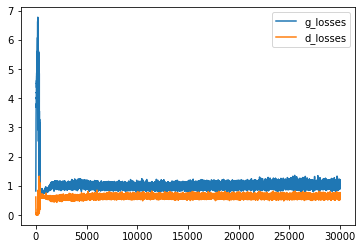

In [ ]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

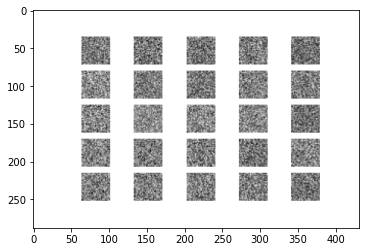

In [ ]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

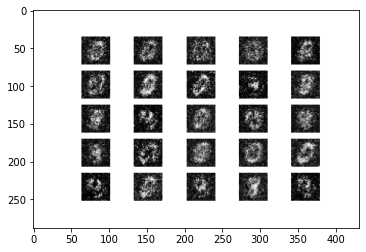

In [ ]:
a = imread('gan_images/600.png')
plt.imshow(a)

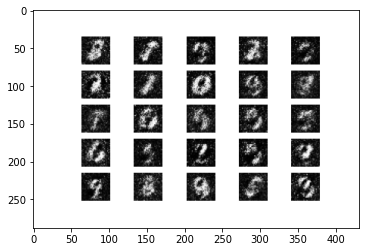

In [ ]:
a = imread('gan_images/1000.png')
plt.imshow(a)

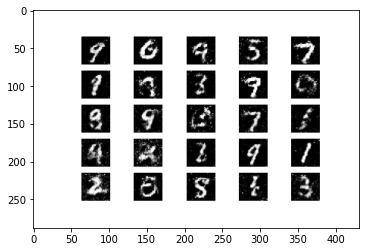

In [ ]:
a = imread('gan_images/5000.png')
plt.imshow(a)

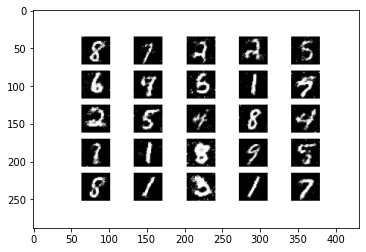

In [ ]:
a = imread('gan_images/10000.png')
plt.imshow(a)

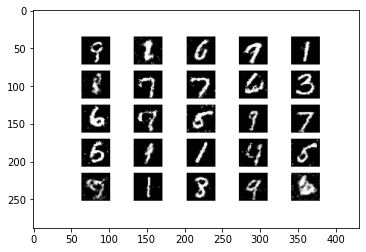

In [ ]:
a = imread('gan_images/20000.png')
plt.imshow(a)

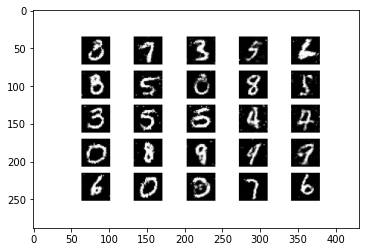

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)